In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Loading Data

In [3]:
recipes = pd.read_csv("epi_r.csv")
shape = recipes.shape
print("Recipes: " + str(shape[0]))
print("Numeric variables: " + str(6))
print("Recipe Categories: " + str(shape[1] - 7))
recipes.head()

Recipes: 20052
Numeric variables: 6
Recipe Categories: 673


,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Preprocessing
- Identified and removed outliers
- Removed rows that contained NaN values

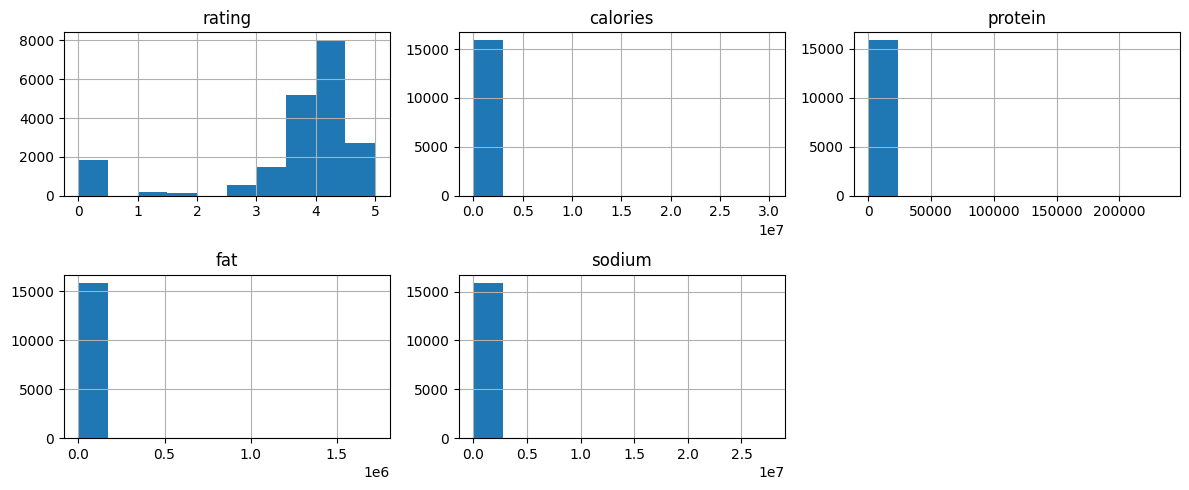

,rating,calories,protein,fat,sodium,dessert
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.178187
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.382679
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000


In [4]:
plt.rcParams["figure.figsize"] = [12, 5]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(2, 3)

pd.DataFrame(recipes['rating']).hist('rating', ax=axes[0,0])
pd.DataFrame(recipes['calories']).hist('calories', ax=axes[0,1])
pd.DataFrame(recipes['protein']).hist('protein', ax=axes[0,2])
pd.DataFrame(recipes['fat']).hist('fat', ax=axes[1,0])
pd.DataFrame(recipes['sodium']).hist('sodium', ax=axes[1,1])
fig.delaxes(axes[1,2])
plt.show()

recipes[['rating', 'calories',  'protein', 'fat', 'sodium', 'dessert']].describe()

In [5]:
recipes = recipes.loc[(recipes.calories < 10000) & (recipes.calories > 0)]
recipes = recipes.loc[recipes.sodium < 100000]
recipes.dropna(inplace=True)
print("Data rows remaining after preprocessing: " + str(recipes.shape[0]))

Data rows remaining after preprocessing: 15832


# Model 1: Logistic Regression
Goal: Use the 5 numeric variables to predict the dessert categorical variable

Challenge: calorie and fat features are strongly correlated

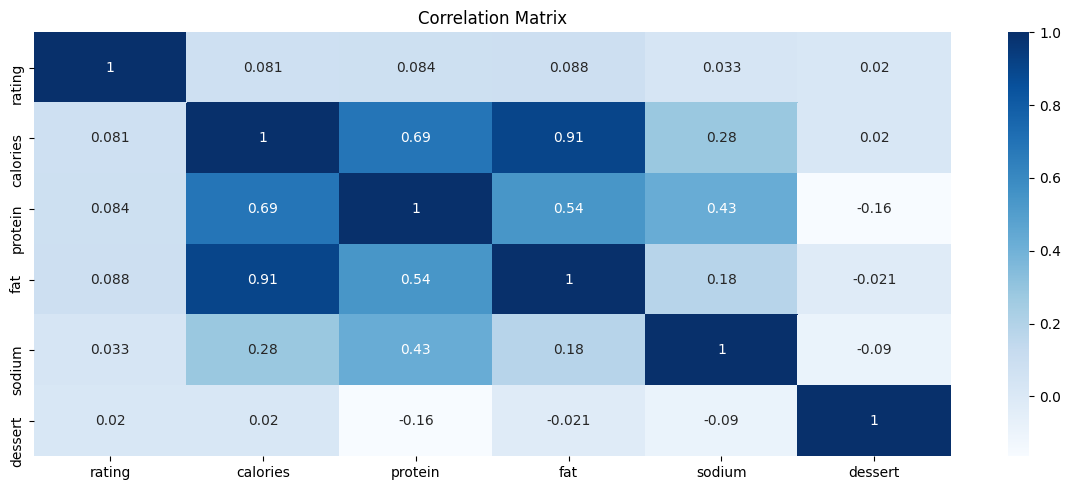

    feature        VIF
0    rating   1.809706
1  calories  14.335761
2   protein   3.060899
3       fat   9.067232
4    sodium   1.334958
5   dessert   1.339997


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

recipes_subset = recipes[['rating', 'calories',  'protein', 'fat', 'sodium', 'dessert']]

cm = recipes_subset.corr()
sns.heatmap(cm,annot = True , cmap = 'Blues')

plt.title("Correlation Matrix")
plt.show()

vif_data = pd.DataFrame()
vif_data["feature"] = recipes_subset.columns
vif_data["VIF"] = [variance_inflation_factor(recipes_subset.values, i)
                          for i in range(len(recipes_subset.columns))]
  
print(vif_data)

### Logisitc Regression - Preprocessing
Standardized the data and then applied PCA with 3 principal components to produce the feature matrix X and target vector y

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = recipes[['rating', 'calories',  'protein', 'fat', 'sodium']]
y = recipes[['dessert']]

scaled_data = StandardScaler().fit(X).transform(X)
X_pca = PCA(n_components=3).fit(scaled_data).transform(scaled_data)


### Model Training
Trained the logistic model on the training X and y split
- Training size size = 75% of total data
- Stratified and shuffled to ensure a percentage of each class in each split

Used cross validation to ensure robustness of the model
- 10 folds

After experimenting with a couple different penalty and solver parameters, I found that they didn't make a huge difference in average accuracy

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

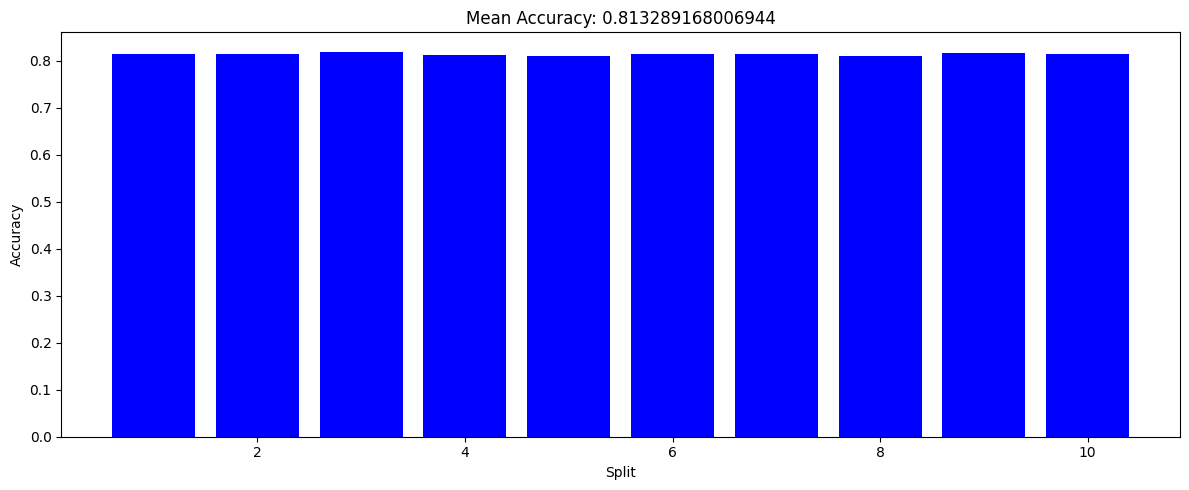

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_pca, y,test_size=0.25, shuffle=True, stratify=y)

logreg = LogisticRegression(penalty='l2', solver='lbfgs', tol = 0.0009)
scores = cross_val_score(logreg, X_train, y_train, cv=10)

plt.bar([1,2,3,4,5,6,7,8,9,10],scores,color='blue')
plt.title("Mean Accuracy: " + str(np.mean(scores)))
plt.xlabel('Split')
plt.ylabel('Accuracy')
plt.show()

### Model Testing
Tested model using the testing X and y split(25% of total data)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


               precision    recall  f1-score   support

Not a dessert       0.82      0.99      0.90     12885
  Is a desset       0.47      0.04      0.07      2947

     accuracy                           0.81     15832
    macro avg       0.64      0.51      0.48     15832
 weighted avg       0.75      0.81      0.74     15832



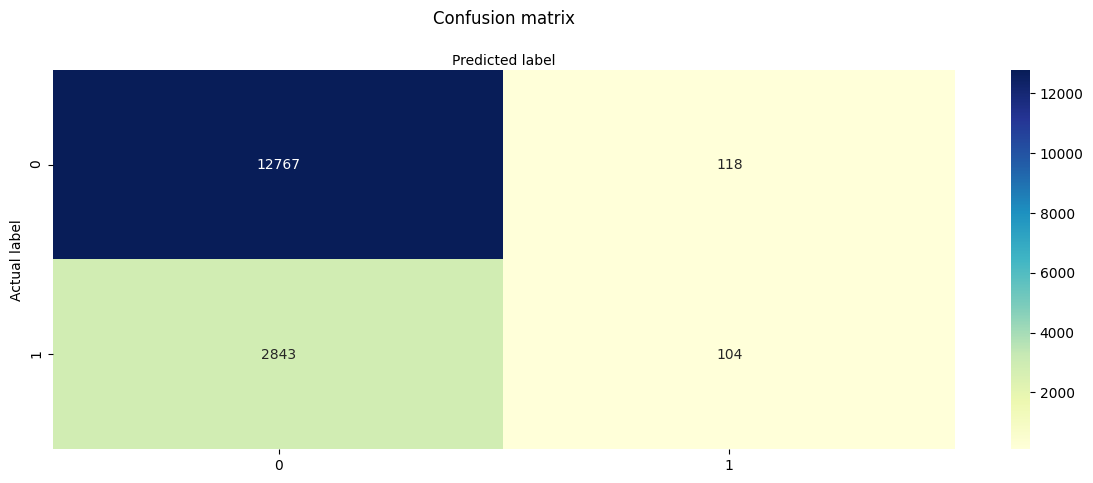

In [10]:
from sklearn.metrics import classification_report

y_pred = logreg.fit(X_test,y_test).predict(X_pca)

cnf_matrix = metrics.confusion_matrix(y, y_pred)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

target_names = ['Not a dessert', 'Is a desset']
print(classification_report(y, y_pred, target_names=target_names))

# Model 2: Decision Tree Classifier
Goal: Use the recipe category features to predict the dessert category

Challenge: the feature matrix is very sparse

In [11]:
recipe_categories = recipes.drop(['title', 'rating', 'calories',  'protein', 'fat', 'sodium'] , axis = 1)

counts = []
for (name, data) in recipe_categories.iteritems():
    if(np.count_nonzero(data.values == 1) > 1000):
        counts.append((name, np.count_nonzero(data.values == 1)))

print('Number of recipes categories (columns): ' + str(recipe_categories.shape[1]))
print('Number of recipe categories with more than 1000 positive values (1): ' + str(len(counts)))

Number of recipes categories (columns): 674
Number of recipe categories with more than 1000 positive values (1): 42


### Training with hyperparameter: PCA Components
Trained the Decision Tree Model using different number of PCA components

Training Model ....
PCA Components: 20, score: 0.9312768232734532
PCA Components: 35, score: 0.9300140551825471
PCA Components: 50, score: 0.9285818732111908
PCA Components: 65, score: 0.9293396617111863
PCA Components: 80, score: 0.9280771063627002
PCA Components: 95, score: 0.9283297734435056
PCA Components: 110, score: 0.9302660131219523
PCA Components: 125, score: 0.9297608207886221
PCA Components: 140, score: 0.9286660482953659
PCA Components: 155, score: 0.9283292061303856
PCA Components: 170, score: 0.9293398035394667
PCA Components: 185, score: 0.9279926476219652
PCA Components: 200, score: 0.9293398035394664
PCA Components: 215, score: 0.9284976272128758
PCA Components: 230, score: 0.928834540291996
PCA Components: 245, score: 0.928666261037786
PCA Components: 260, score: 0.9284133812145606
PCA Components: 275, score: 0.9294242622802015
PCA Components: 290, score: 0.9286661901236458
PCA Components: 305, score: 0.9284135230428406
PCA Components: 320, score: 0.9281608559620353
P

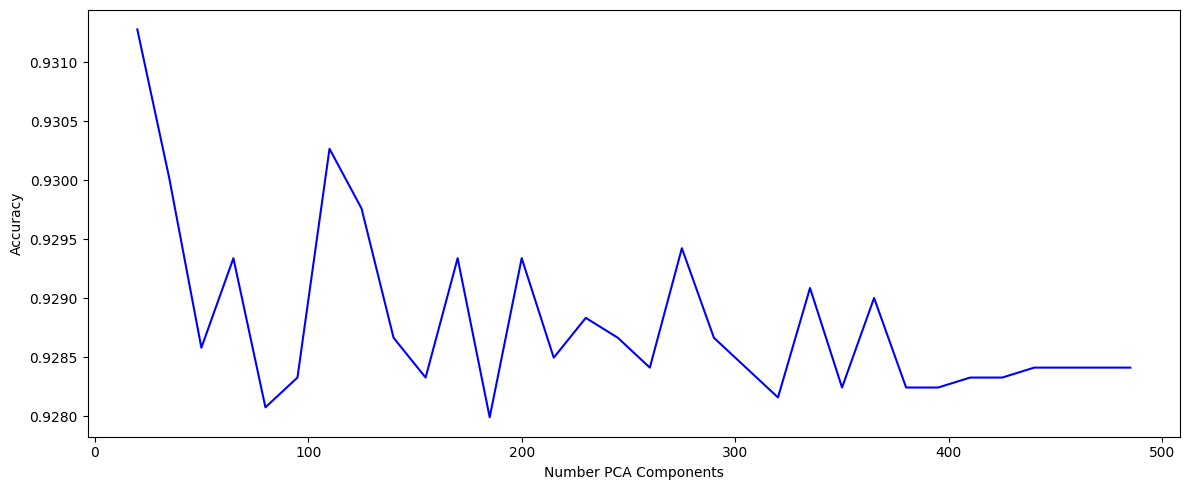

Maximum Accuracy Achieved: 0.9312768232734532 with PCA components = 20


In [12]:
from sklearn.tree import DecisionTreeClassifier

recipe_categories = recipes.drop(['rating', 'calories',  'protein', 'fat', 'sodium'] , axis = 1)
X = recipe_categories.drop(['title','dessert'], axis=1)
y = recipe_categories['dessert']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, shuffle=True, stratify=y)

step = []
score = []
max_acc_model = DecisionTreeClassifier()
max_acc_score = 0
max_pca = 0

print("Training Model ....")
for i in range(20, 500, 15):
    scaled_data = StandardScaler().fit(X_train).transform(X_train)
    X_pca = PCA(n_components=i).fit(scaled_data).transform(scaled_data)

    clf = DecisionTreeClassifier(criterion='entropy', splitter='best', min_impurity_decrease=0.008,min_samples_split=3)
    scores = cross_val_score(clf, X_pca, y_train, cv=10)
    step.append(i)
    score.append(np.mean(scores))
    if(np.mean(scores) > max_acc_score and np.mean(scores) < 1):
        max_acc_score = np.mean(scores)
        max_acc_model = clf
        max_pca = i
    print('PCA Components: ' + str(i) + ", score: " + str(np.mean(scores)))

print("Training Complete")
plt.plot(step,score,color='blue')
plt.xlabel('Number PCA Components')
plt.ylabel('Accuracy')
plt.show()

print("Maximum Accuracy Achieved: " + str(max_acc_score) + " with PCA components = " + str(max_pca))

Training Model ....
PCA Components: 20, score: 0.9398684968187918
PCA Components: 35, score: 0.9413001114770282
PCA Components: 50, score: 0.9390263204922009
PCA Components: 65, score: 0.9388581121521307
PCA Components: 80, score: 0.9393636590561613
PCA Components: 95, score: 0.9392792003154262
PCA Components: 110, score: 0.9396159715662666
PCA Components: 125, score: 0.9410479407952028
PCA Components: 140, score: 0.9391949543171112
PCA Components: 155, score: 0.9398688513894917
PCA Components: 170, score: 0.9385215536437104
PCA Components: 185, score: 0.9388583248945507
PCA Components: 200, score: 0.9398687804753518
PCA Components: 215, score: 0.9388583958086908
PCA Components: 230, score: 0.9390266041487608
PCA Components: 245, score: 0.9386897619837805
PCA Components: 260, score: 0.9392794130578462
PCA Components: 275, score: 0.9388582539804107
PCA Components: 290, score: 0.9384371658171153
PCA Components: 305, score: 0.9386056578137454
PCA Components: 320, score: 0.9385214118154304

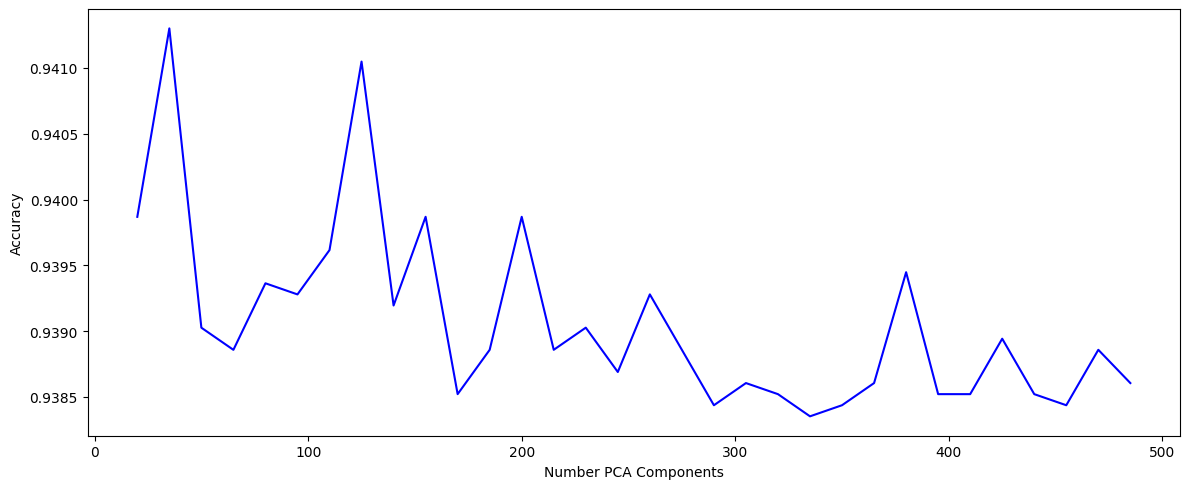

Maximum Accuracy Achieved: 0.9413001114770282 with PCA components = 35


In [13]:
from sklearn.tree import DecisionTreeClassifier

recipe_categories = recipes.drop(['rating', 'calories',  'protein', 'fat', 'sodium'] , axis = 1)
X = recipe_categories.drop(['title','dessert'], axis=1)
y = recipe_categories['dessert']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, shuffle=True, stratify=y)

step = []
score = []
max_acc_model = DecisionTreeClassifier()
max_acc_score = 0
max_pca = 0

print("Training Model ....")
for i in range(20, 500, 15):
    scaled_data = StandardScaler().fit(X_train).transform(X_train)
    X_pca = PCA(n_components=i).fit(scaled_data).transform(scaled_data)

    clf = DecisionTreeClassifier(criterion='gini', splitter='best', min_impurity_decrease=0.008,min_samples_split=3)
    scores = cross_val_score(clf, X_pca, y_train, cv=10)
    step.append(i)
    score.append(np.mean(scores))
    if(np.mean(scores) > max_acc_score and np.mean(scores) < 1):
        max_acc_score = np.mean(scores)
        max_acc_model = clf
        max_pca = i
    print('PCA Components: ' + str(i) + ", score: " + str(np.mean(scores)))

print("Training Complete")
plt.plot(step,score,color='blue')
plt.xlabel('Number PCA Components')
plt.ylabel('Accuracy')
plt.show()

print("Maximum Accuracy Achieved: " + str(max_acc_score) + " with PCA components = " + str(max_pca))

### Model Testing
Tested model using the testing X and y split(25% of total data)

               precision    recall  f1-score   support

Not a dessert       0.96      0.97      0.96      3221
  Is a desset       0.85      0.83      0.84       737

     accuracy                           0.94      3958
    macro avg       0.91      0.90      0.90      3958
 weighted avg       0.94      0.94      0.94      3958



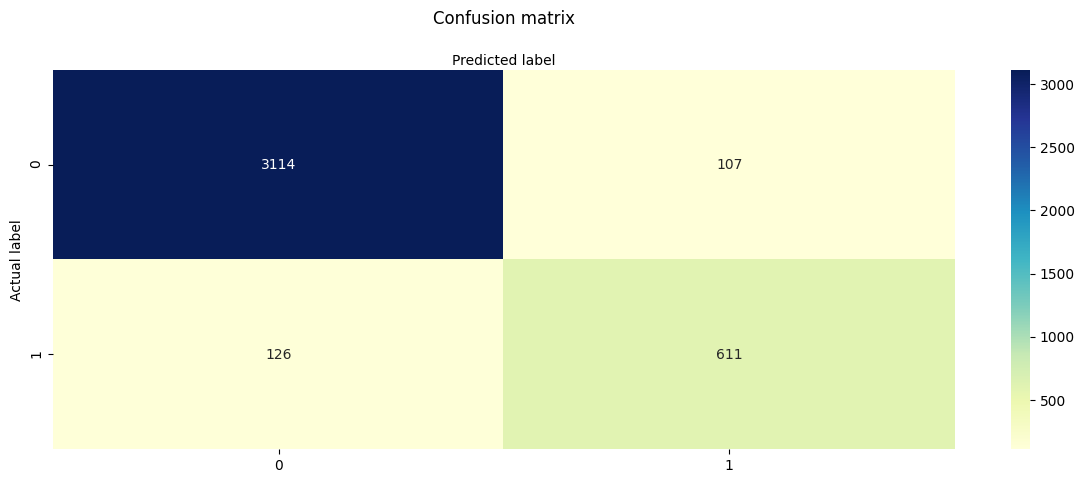

In [14]:
scaled_data = StandardScaler().fit(X_test).transform(X_test)
X_pca = PCA(n_components=i).fit(scaled_data).transform(scaled_data)

y_pred = max_acc_model.fit(X_pca, y_test).predict(X_pca)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

target_names = ['Not a dessert', 'Is a desset']
print(classification_report(y_test, y_pred, target_names=target_names))

# Summary

Used a Logistic Regression Model to predict the dessert category from the recipe nutritional information
- Found that calories is strongly correlated with fat
- Used PCA to reduce multicollinearity 
- Choice of model heuristics did not make a huge difference in performance
- Average training accuracy: 0.81
- Very low recall and f1 scores for 'Is a dessert'

Used a Decision Tree Classifier to predict dessert category from the other recipe categories
- Data very sparse, used PCA to condense feature matrix
- Tuned the hyperparameter: Number of PCA Components
- Tried splitting criterion Entropy(training accuracy = 0.93953 with 50 PCA components) and Gini(training accuracy = 0.9455 with 110 PCA components)
- Final predictions made with Gini and 110 PCA components
- Precision, recall, and f1 scores much improved from the logistic regression